# CNN with K=5 with lung masks

Model adpeted from:
https://ieeexplore.ieee.org/abstract/document/9057809

Grayscale - 1 Channel CXR

\+ Unet dialted lung masks in second channel

In [84]:
import pandas as pd
import math
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from pathlib import Path
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, AveragePooling2D, Conv2D, MaxPool2D, Activation, GlobalAveragePooling2D, Lambda
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [85]:
# Config
IMG_SIZE = 256
BATCH_SIZE=32
CHANNELS=2
USE_MASKS=True
MODELSAVE = "models/cnn_gray_030121"

if(USE_MASKS):
    MODELSAVE += "_w_masks.h5"
else:
    MODELSAVE += "_wo_masks.h5"


# train_path = '/home/daniel/.kaggle/mooney/chest_xray/train/'
# test_path = '/home/8cb7/.kaggle/mooney/chest_xray/test/'
# val_path = '/home/8cb7/.kaggle/mooney/chest_xray/val/'

train_path = '/home/daniel/dev/python/chest_x_ray/data/mooney/train/'
test_path = '/home/daniel/dev/python/chest_x_ray/data/mooney/test/'
val_path = '/home/daniel/dev/python/chest_x_ray/data/mooney/val/'

train_mask_path = '/home/daniel/dev/python/chest_x_ray/data/mooney/masks/train/'
val_mask_path = '/home/daniel/dev/python/chest_x_ray/data/mooney/masks/val/'
test_mask_path = '/home/daniel/dev/python/chest_x_ray/data/mooney/masks/test/'

# train_mask_path = '/home/8cb7/.kaggle/mooney/chest_xray/masks/train/'
# val_mask_path = '/home/8cb7/.kaggle/mooney/chest_xray/masks/val/'
# test_mask_path = '/home/8cb7/.kaggle/mooney/chest_xray/masks/test/'

# covid19
covid_path = '/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/output'
covid_mask_path = '/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/masks/'

In [86]:
USE_MASKS

True

In [87]:
# np.random.seed(200)
# tf.random.set_seed(200)

## 1 Data preparation

In [88]:
def load_images_from_folder(img_folder, masks_folder):
    tmp_df = pd.DataFrame(columns = ['img', 'label', 'mask']) 
    # IMGs
    for label_folder in os.listdir(img_folder):
        for filename in os.listdir(img_folder + '/' + label_folder):
            img_path = str(img_folder)+str(label_folder)+'/'+str(filename)
            # normal file ending is jpEg...
            filename_wo_ending = filename.split('.jpeg')[0]

            mask_path = None
            if masks_folder is not None:
                mask_path = str(masks_folder)+str(label_folder)+'/'+str(filename_wo_ending) + '_predmask.jpg'

            label2 = '-'
            if img_path is not None:
                if label_folder != 'NORMAL':
                    label2 = filename_wo_ending.split("_")[1].split("_")[0]

                tmp_df = tmp_df.append({'img': img_path, 'mask': mask_path, 'label': label_folder, 'label2': label2, 'label3': '-'}, ignore_index=True)

    return tmp_df

In [89]:
def load_covid_images_from_folder(img_folder, masks_folder):
    tmp_df = pd.DataFrame(columns = ['img', 'label', 'mask']) 
    for filename in os.listdir(img_folder):
        img_path = str(img_folder)+'/'+str(filename)
        label = 'PNEUMONIA' # virurs => covid19
        # normal file ending is jpEg...
        filename_wo_ending = filename.rsplit('.')[0]
        mask_path = str(masks_folder)+str(filename_wo_ending) + '_predmask.jpg'
        if img_path is not None:
            tmp_df = tmp_df.append({'img': img_path,  'mask': mask_path, 'label': label, 'label2': 'virus', 'label3': 'covid19'}, ignore_index=True)

    return tmp_df

In [90]:
df_train = load_images_from_folder(train_path, train_mask_path)
df_val = load_images_from_folder(val_path, val_mask_path)
df_test = load_images_from_folder(test_path, test_mask_path)
df_covid = load_covid_images_from_folder(covid_path, covid_mask_path)

In [91]:
df_train.shape

(5216, 5)

In [92]:
df_train = df_train.append(df_val, ignore_index=True) # append val to train since we are using k-fold cv

In [93]:
df_train.shape

(5232, 5)

In [94]:
df_covid.head()

,img,label,mask,label2,label3
0,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/output/a2eba651.jpg,PNEUMONIA,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/masks/a2eba651_predmask.jpg,virus,covid19
1,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/output/nejmoa2001191_f1-PA.jpeg,PNEUMONIA,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/masks/nejmoa2001191_f1-PA_predmask.jpg,virus,covid19
2,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/output/7-fatal-covid19.jpg,PNEUMONIA,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/masks/7-fatal-covid19_predmask.jpg,virus,covid19
3,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/output/ciaa199.pdf-001-a.png,PNEUMONIA,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/masks/ciaa199_predmask.jpg,virus,covid19
4,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/output/7AF6C1AF-D249-4BD2-8C26-449304105D03.jpeg,PNEUMONIA,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/masks/7AF6C1AF-D249-4BD2-8C26-449304105D03_predmask.jpg,virus,covid19


In [95]:
# Split covid19 data
from sklearn.model_selection import train_test_split
df_train_covid, df_test_covid = train_test_split(df_covid, test_size=0.2, random_state=200)

In [96]:
print('=== Covid Data: ===')
print('Train:', len(df_train_covid))
print('Test:', len(df_test_covid))

=== Covid Data: ===
Train: 156
Test: 40


In [97]:
pd.set_option('display.max_colwidth', -1)
df_train_covid

,img,label,mask,label2,label3
166,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/output/3b46de94.jpg,PNEUMONIA,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/masks/3b46de94_predmask.jpg,virus,covid19
80,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/output/1-s2.0-S0140673620303706-fx1_lrg.jpg,PNEUMONIA,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/masks/1-s2_predmask.jpg,virus,covid19
174,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/output/48c4542c.jpg,PNEUMONIA,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/masks/48c4542c_predmask.jpg,virus,covid19
180,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/output/2C26F453-AF3B-4517-BB9E-802CF2179543.jpeg,PNEUMONIA,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/masks/2C26F453-AF3B-4517-BB9E-802CF2179543_predmask.jpg,virus,covid19
163,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/output/23E99E2E-447C-46E5-8EB2-D35D12473C39.png,PNEUMONIA,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/masks/23E99E2E-447C-46E5-8EB2-D35D12473C39_predmask.jpg,virus,covid19
...,...,...,...,...,...
42,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/output/covid-19-pneumonia-rapidly-progressive-3-days.jpg,PNEUMONIA,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/masks/covid-19-pneumonia-rapidly-progressive-3-days_predmask.jpg,virus,covid19
68,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/output/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-002-fig3a.png,PNEUMONIA,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/masks/1_predmask.jpg,virus,covid19
16,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/output/ryct.2020200034.fig5-day0.jpeg,PNEUMONIA,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/masks/ryct_predmask.jpg,virus,covid19
105,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/output/covid-19-pneumonia-rapidly-progressive-12-hours.jpg,PNEUMONIA,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/masks/covid-19-pneumonia-rapidly-progressive-12-hours_predmask.jpg,virus,covid19


In [98]:
# Append Covid19 data to rest
df_train = df_train.append(df_train_covid, ignore_index=True)
df_test = df_test.append(df_test_covid, ignore_index=True)

In [99]:
print('=== Train Data: ===')
print('Normal:', len(df_train[df_train['label'] == 'NORMAL']))
print('Pneumonia:', len(df_train[df_train['label'] == 'PNEUMONIA']))
print('|---> Bacterial:', len(df_train[df_train['label2'] == 'bacteria']))
print('|---> Viral:', len(df_train[df_train['label2'] == 'virus']))
print('    |---> Covid:', len(df_train[df_train['label3'] == 'covid19']))

=== Train Data: ===
Normal: 1349
Pneumonia: 4039
|---> Bacterial: 2538
|---> Viral: 1501
    |---> Covid: 156


In [100]:
print('=== Test Data: ===')
print('Normal:', len(df_test[df_test['label'] == 'NORMAL']))
print('Pneumonia:', len(df_test[df_test['label'] == 'PNEUMONIA']))
print('|---> Bacterial:', len(df_test[df_test['label2'] == 'bacteria']))
print('|---> Viral:', len(df_test[df_test['label2'] == 'virus']))
print('    |---> Covid:', len(df_test[df_test['label3'] == 'covid19']))

=== Test Data: ===
Normal: 234
Pneumonia: 430
|---> Bacterial: 242
|---> Viral: 188
    |---> Covid: 40


In [101]:
# Shuffle
df_train = df_train.sample(frac=1, random_state=200).reset_index(drop=True)
df_test = df_test.sample(frac=1, random_state=200).reset_index(drop=True)

In [102]:
def replace_by_binary_class(df, to_replace, value):
    return df.replace(to_replace=to_replace, value=value)

In [103]:
df_train = replace_by_binary_class(df_train, 'NORMAL', 0)
df_train = replace_by_binary_class(df_train, 'PNEUMONIA', 1)

df_test = replace_by_binary_class(df_test, 'NORMAL', 0)
df_test = replace_by_binary_class(df_test, 'PNEUMONIA', 1)

In [104]:
df_train.head()

,img,label,mask,label2,label3
0,/home/daniel/dev/python/chest_x_ray/data/mooney/train/NORMAL/IM-0409-0001.jpeg,0,/home/daniel/dev/python/chest_x_ray/data/mooney/masks/train/NORMAL/IM-0409-0001_predmask.jpg,-,-
1,/home/daniel/dev/python/chest_x_ray/data/mooney/train/PNEUMONIA/person471_bacteria_2004.jpeg,1,/home/daniel/dev/python/chest_x_ray/data/mooney/masks/train/PNEUMONIA/person471_bacteria_2004_predmask.jpg,bacteria,-
2,/home/daniel/dev/python/chest_x_ray/data/mooney/train/NORMAL/NORMAL2-IM-1043-0001.jpeg,0,/home/daniel/dev/python/chest_x_ray/data/mooney/masks/train/NORMAL/NORMAL2-IM-1043-0001_predmask.jpg,-,-
3,/home/daniel/dev/python/chest_x_ray/data/mooney/train/PNEUMONIA/person806_virus_1439.jpeg,1,/home/daniel/dev/python/chest_x_ray/data/mooney/masks/train/PNEUMONIA/person806_virus_1439_predmask.jpg,virus,-
4,/home/daniel/dev/python/chest_x_ray/data/mooney/train/NORMAL/NORMAL2-IM-1008-0001.jpeg,0,/home/daniel/dev/python/chest_x_ray/data/mooney/masks/train/NORMAL/NORMAL2-IM-1008-0001_predmask.jpg,-,-



## 2 Data generator

In [105]:
import imgaug.augmenters as iaa
aug = iaa.AllChannelsCLAHE(clip_limit=(0.05))

In [106]:
def applySigmoidContrast(img):
    img = aug.augment_image(img)
    return img

In [107]:
import imgaug as ia
import imgaug.augmenters as iaa

sometimes = lambda aug: iaa.Sometimes(0.5, aug)
sometimes25 = lambda aug: iaa.Sometimes(0.25, aug)

seq_img = iaa.Sequential([
    # sometimes(iaa.SigmoidContrast(gain=(3, 10), cutoff=(0.4, 0.6))),
    sometimes(iaa.Affine(
            rotate=(-10, 10),
            shear=(-10,10),
            scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}
    )),
    sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.15))),
], random_order=True)

class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, df, augment, img_size, batch_size=8, shuffle=True, useMasks=True):
        self.batch_size = batch_size
        self.df = df
        self.indices = self.df.index.tolist()
        self.shuffle = shuffle
        self.augment = augment
        self.img_size = img_size
        self.useMasks = useMasks

    def __len__(self):
        return math.ceil(len(self.indices)/ self.batch_size)

    def __getitem__(self, index):
        indexes = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in indexes]
        X, y = self.__get_data(batch)
        return np.array(X), np.array(y)

    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def __get_data(self, batch):
        X_img_paths = self.df['img']
        X_mask_paths = self.df['mask']
        X_imgs = []
        X_masks = []
        Y = self.df['label'].iloc[batch].to_numpy()

        for i in range(0, len(batch)):
            img = cv2.resize(cv2.imread(str(X_img_paths.iloc[batch[i]]), cv2.IMREAD_GRAYSCALE), (self.img_size, self.img_size))
            img = img.reshape(img.shape[0], img.shape[1],1)

            if not self.useMasks:
                if(self.augment is True):
                    seq_img_i = seq_img.to_deterministic()   
                    img = seq_img_i.augment_image(img)
                # else img remains untouched
            else: 
                mask = cv2.imread(str(X_mask_paths.iloc[batch[i]]), cv2.IMREAD_GRAYSCALE)
                #mask = cv2.resize(mask, (self.img_size, self.img_size))
                mask = cv2.threshold(mask,0,1,cv2.THRESH_BINARY)[1]
                # Multiply binarized mask on grayscaled version of the x-ray. 
                # So only the lung will remain, everything else will be set to 0
                try:
                    mask = mask.reshape(IMG_SIZE,IMG_SIZE,1)
                except:
                    print("i", i)
                    print(str(X_mask_paths.iloc[batch[i]]))
                cutout_img = img * mask
                cutout_img = cutout_img.reshape(IMG_SIZE,IMG_SIZE,1)

                if(self.augment is True):
                    seq_img_i = seq_img.to_deterministic()   
                    img = seq_img_i.augment_image(img) #### img
                    cutout_img = seq_img_i.augment_image(cutout_img) #### cutout

                img = np.dstack([img, cutout_img])
                mask = mask / 255.0

            # normalize
            img = img / 255.0

            X_imgs.append(img)

        return X_imgs, Y

## 3 Model training

In [108]:
def getModel():
    model = Sequential()
    # Conv block1 = cb0
    model.add(Conv2D(32, (3,3), padding = "same", activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS), name="cb0_conv0"))
    model.add(Conv2D(32, (3,3), padding = "same", activation='relu', name="cb0_conv1"))
    model.add(MaxPool2D(pool_size = (3, 3), name="cb0_maxpool"))
    model.add(Dropout(0.2, name="cb0_dropout"))

    # Conv block2 = cb1
    model.add(Conv2D(64, (3,3), padding = "same", activation='relu', name="cb1_conv0"))
    model.add(Conv2D(64, (5,5), strides=(2,2), padding = "same", activation='relu', name="cb1_conv1"))
    model.add(Conv2D(64, (3,3), padding = "same", activation='relu', name="cb1_conv2"))
    model.add(MaxPool2D(pool_size = (2, 2), name="cb1_maxpool"))
    model.add(Dropout(0.2, name="cb1_dropout"))

    # Dense block = db
    model.add(Flatten())
    model.add(Dense(1024, activation='relu', name="db_dense1024"))
    model.add(Dense(512, activation='relu', name="db_dense512"))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu', name="db_dense256"))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='sigmoid', name="db_dense1"))

    model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [109]:
# K-Fold
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, accuracy_score

In [110]:
kf5 = StratifiedKFold(n_splits=5, random_state=200)

In [111]:
run = 1
val_scores = []
f1_scores = []
histories = []
best_f1_model = None
highestF1 = 0
EPOCHS = 12

for train_index, val_index in kf5.split(df_train, df_train.label):
    print("Fold Nr.: ", run)
    df_fold_train = df_train.iloc[train_index]
    df_fold_val = df_train.iloc[val_index]

    df_fold_train.reset_index(drop=True, inplace=True)
    df_fold_val.reset_index(drop=True, inplace=True)
    
    
    # print('=== Train Data: ===')
    # print('Normal:', len(df_fold_train[df_fold_train['label'] == 0]))
    # print('Pneumonia:', len(df_fold_train[df_fold_train['label'] == 1]))
    # print('|---> Bacterial:', len(df_fold_train[df_fold_train['label2'] == 'bacteria']))
    # print('|---> Viral:', len(df_fold_train[df_fold_train['label2'] == 'virus']))
    # print('    |---> Covid:', len(df_fold_train[df_fold_train['label3'] == 'covid19']))
    
    # print('=== Val Data: ===')
    # print('Normal:', len(df_fold_val[df_fold_val['label'] == 0]))
    # print('Pneumonia:', len(df_fold_val[df_fold_val['label'] == 1]))
    # print('|---> Bacterial:', len(df_fold_val[df_fold_val['label2'] == 'bacteria']))
    # print('|---> Viral:', len(df_fold_val[df_fold_val['label2'] == 'virus']))
    # print('    |---> Covid:', len(df_fold_val[df_fold_val['label3'] == 'covid19']))
    
    train_generator = DataGenerator(df_fold_train, True, IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False, useMasks=USE_MASKS)
    val_generator = DataGenerator(df_fold_val, False, IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False, useMasks=USE_MASKS)
    

    # Adjust class_weights since we're dealing with imbalanced data here
    class_weights = class_weight.compute_class_weight('balanced', np.unique(df_fold_train['label']), df_fold_train['label'])
    class_weights = {0: class_weights[0], 1: class_weights[1]}
    print("Class weights: ", class_weights)

    model = getModel()
    history = model.fit(train_generator,
                    validation_data=val_generator,
                    validation_steps=len(val_generator),
                    steps_per_epoch=len(train_generator),
                    epochs=EPOCHS,
                    class_weight=class_weights,
                    #callbacks=[mcp_save, learning_rate_reduction], # learning_rate_reduction]],
                    verbose = True)

    predictions = model.predict(val_generator)
    y_pred = (predictions > 0.5).astype('uint8')

    histories.append(history)

    f1 = f1_score(y_pred, df_fold_val.label)

    if(highestF1 is 0):
        highestF1 = f1
        best_f1_model = model
    else:
        if(f1 > highestF1):
            highestF1 = f1
            best_f1_model = model

    val_acc = accuracy_score(y_pred , df_fold_val.label)

    f1_scores.append(f1)
    val_scores.append(val_acc)
    
    run += 1

Fold Nr.:  1
Class weights:  {0: 1.9972196478220574, 1: 0.666976168368926}
Epoch 1/12
135/135 [==============================] - 45s 331ms/step - loss: 0.3712 - accuracy: 0.8007 - val_loss: 0.1689 - val_accuracy: 0.9314
Epoch 2/12
135/135 [==============================] - 45s 330ms/step - loss: 0.2243 - accuracy: 0.8961 - val_loss: 0.1034 - val_accuracy: 0.9610
Epoch 3/12
135/135 [==============================] - 44s 328ms/step - loss: 0.1890 - accuracy: 0.9258 - val_loss: 0.1769 - val_accuracy: 0.9323
Epoch 4/12
135/135 [==============================] - 45s 330ms/step - loss: 0.1826 - accuracy: 0.9195 - val_loss: 0.1388 - val_accuracy: 0.9443
Epoch 5/12
135/135 [==============================] - 45s 335ms/step - loss: 0.1571 - accuracy: 0.9346 - val_loss: 0.0923 - val_accuracy: 0.9685
Epoch 6/12
135/135 [==============================] - 44s 326ms/step - loss: 0.1584 - accuracy: 0.9332 - val_loss: 0.0760 - val_accuracy: 0.9694
Epoch 7/12
135/135 [==============================] - 4

In [112]:
np.array(f1_scores).mean()

0.9924358413350752

In [113]:
np.array(val_scores).mean()

0.9886782669512474

In [134]:
# set model to the best f1 model
model = best_f1_model

In [135]:
# val_accs = []
# for i in range(0, len(histories)):
#     history = histories[i]
#     acc = history.history['accuracy']
#     val_acc = history.history['val_accuracy']
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']
#     val_accs.append(val_acc[1])
#     print("#",i)
#     print("-- acc: ", acc)
#     print("-- val_acc: ", val_acc)

#     # epochs = range(1, len(acc) + 1)
#     # plt.plot(epochs, acc, 'blue', label='Training acc')
#     # plt.plot(epochs, val_acc, 'red', label='Validation acc')
#     # plt.title('Training and validation accuracy')
#     # plt.legend()
#     # plt.figure()
#     # plt.plot(epochs, loss, 'blue', label='Training loss')
#     # plt.plot(epochs, val_loss, 'red', label='Validation loss')
#     # plt.title('Training and validation loss')
#     # plt.legend()
#     # plt.show()

In [136]:
# a = np.array(val_accs)

In [137]:
# a.std(), a.mean()

In [138]:
# mcp_save = ModelCheckpoint(MODELSAVE, save_best_only=True, monitor='val_loss', mode='min')
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 0, verbose=1,factor=0.01, min_lr=0.000001, min_delta=0.001)
# earlystopping = EarlyStopping(monitor='val_accuracy',
#                               min_delta=0,
#                               patience=1,
#                               verbose=0, mode='auto')

In [139]:
# history = model.fit(train_generator,
#                     validation_data=val_generator,
#                     validation_steps=len(val_generator),
#                     steps_per_epoch=len(train_generator),
#                     epochs=12,
#                     class_weight=class_weights,
#                     callbacks=[mcp_save, learning_rate_reduction], # learning_rate_reduction]],
#                     verbose = True)

In [140]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(1, len(acc) + 1)
# plt.plot(epochs, acc, 'blue', label='Training acc')
# plt.plot(epochs, val_acc, 'red', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.legend()
# plt.figure()
# plt.plot(epochs, loss, 'blue', label='Training loss')
# plt.plot(epochs, val_loss, 'red', label='Validation loss')
# plt.title('Training and validation loss')
# plt.legend()
# plt.show()

## 4 Model evaluation

In [141]:
# model = tf.keras.models.load_model("models/custom_0709_womasks.h5", compile=True)

In [142]:
df_test.head()

,img,label,mask,label2,label3
0,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/output/covid-19-pneumonia-mild.JPG,1,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/masks/covid-19-pneumonia-mild_predmask.jpg,virus,covid19
1,/home/daniel/dev/python/chest_x_ray/data/mooney/test/PNEUMONIA/person100_bacteria_481.jpeg,1,/home/daniel/dev/python/chest_x_ray/data/mooney/masks/test/PNEUMONIA/person100_bacteria_481_predmask.jpg,bacteria,-
2,/home/daniel/dev/python/chest_x_ray/data/mooney/test/NORMAL/NORMAL2-IM-0372-0001.jpeg,0,/home/daniel/dev/python/chest_x_ray/data/mooney/masks/test/NORMAL/NORMAL2-IM-0372-0001_predmask.jpg,-,-
3,/home/daniel/dev/python/chest_x_ray/data/mooney/test/NORMAL/NORMAL2-IM-0120-0001.jpeg,0,/home/daniel/dev/python/chest_x_ray/data/mooney/masks/test/NORMAL/NORMAL2-IM-0120-0001_predmask.jpg,-,-
4,/home/daniel/dev/python/chest_x_ray/data/mooney/test/PNEUMONIA/person171_bacteria_826.jpeg,1,/home/daniel/dev/python/chest_x_ray/data/mooney/masks/test/PNEUMONIA/person171_bacteria_826_predmask.jpg,bacteria,-


In [143]:
test_generator = DataGenerator(df_test, False, IMG_SIZE, batch_size=32, shuffle=False, useMasks=USE_MASKS)

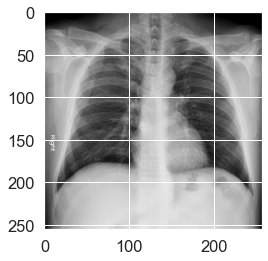

In [144]:
plt.imshow(test_generator.__getitem__(0)[0][0][:,:,0], cmap="gray")

In [145]:
model.evaluate(test_generator)

21/21 [==============================] - 4s 172ms/step - loss: 0.2440 - accuracy: 0.9066


[0.24399042129516602, 0.9066265225410461]

In [146]:
print("Test pneumonia cases: ", len(df_test[df_test['label'] == 1]))
print("Test normal cases: ", len(df_test[df_test['label'] == 0]))

Test pneumonia cases:  430
Test normal cases:  234


## Detail eval

In [147]:
predictions = model.predict(test_generator)

In [148]:
y_true = test_generator.df.label # we can do this since we do not shuffle in test_generator ;)
y_pred = predictions > 0.5

In [149]:
y_pred_classes = []

for x in y_pred:
    if x == 0:
        y_pred_classes.append("NORMAL")
    else:
        y_pred_classes.append("PNEUMONIA")

In [150]:
y_true_classes = []

for x in y_true:
    if x == 0:
        y_true_classes.append("NORMAL")
    else:
        y_true_classes.append("PNEUMONIA")

In [151]:
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[176  58]
 [  4 426]]


In [152]:
report = classification_report(y_true_classes, y_pred_classes) #, target_names=["NORMAL", "PNEUMONIA"])
print(report)

              precision    recall  f1-score   support

      NORMAL       0.98      0.75      0.85       234
   PNEUMONIA       0.88      0.99      0.93       430

    accuracy                           0.91       664
   macro avg       0.93      0.87      0.89       664
weighted avg       0.91      0.91      0.90       664



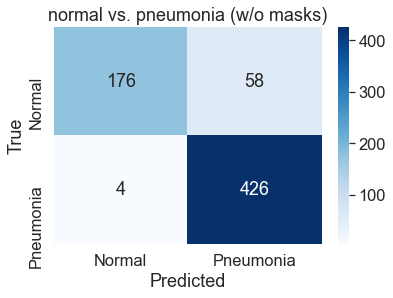

In [153]:
import seaborn as sns
import matplotlib.pyplot as plt
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues'); #annot=True to annotate cells
sns.set(font_scale=1.5)

# labels, title and ticks
ax.set_xlabel('Predicted');
ax.set_ylabel('True'); 
ax.set_title('normal vs. pneumonia (w/o masks)'); 
ax.xaxis.set_ticklabels(['Normal', 'Pneumonia']); ax.yaxis.set_ticklabels(['Normal', 'Pneumonia']);